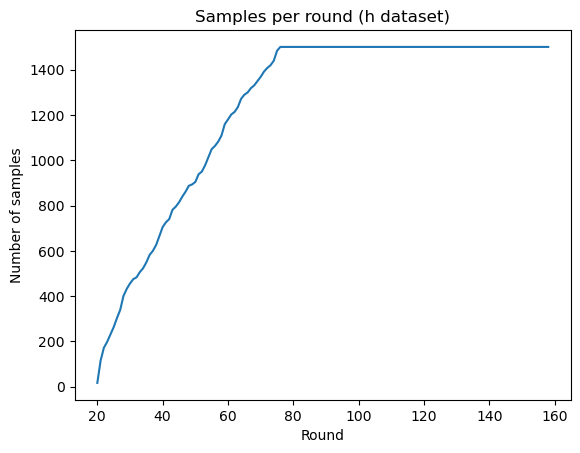

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Adjust this to your dataset folder
data_dir = Path("datasets/openimage_bliss")

# Find the most recent h_*.csv file
csv_files = sorted(data_dir.glob("h_*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No h_*.csv files found in {data_dir}")
latest_csv = csv_files[-1]

# Load it
df = pd.read_csv(latest_csv)

# Count samples per round
round_counts = df.groupby("round").size().sort_index()

# Plot
plt.figure()
plt.plot(round_counts.index, round_counts.values)
plt.xlabel("Round")
plt.ylabel("Number of samples")
plt.title("Samples per round (h dataset)")
plt.show()

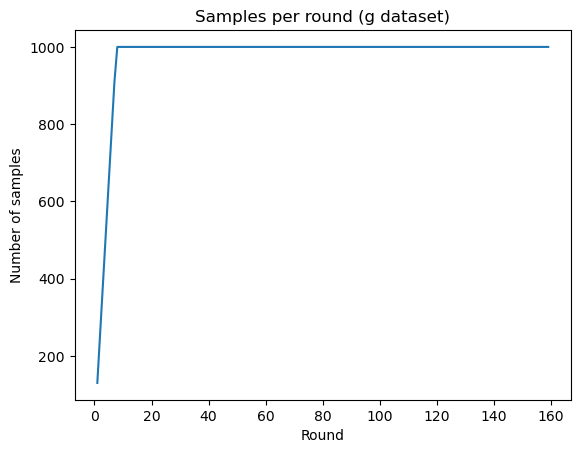

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Adjust this to your dataset folder
data_dir = Path("datasets/openimage_bliss")

# Find the most recent h_*.csv file
csv_files = sorted(data_dir.glob("g_*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No g_*.csv files found in {data_dir}")
latest_csv = csv_files[-1]

# Load it
df = pd.read_csv(latest_csv)

# Count samples per round
round_counts = df.groupby("round").size().sort_index()

# Plot
plt.figure()
plt.plot(round_counts.index, round_counts.values)
plt.xlabel("Round")
plt.ylabel("Number of samples")
plt.title("Samples per round (g dataset)")
plt.show()

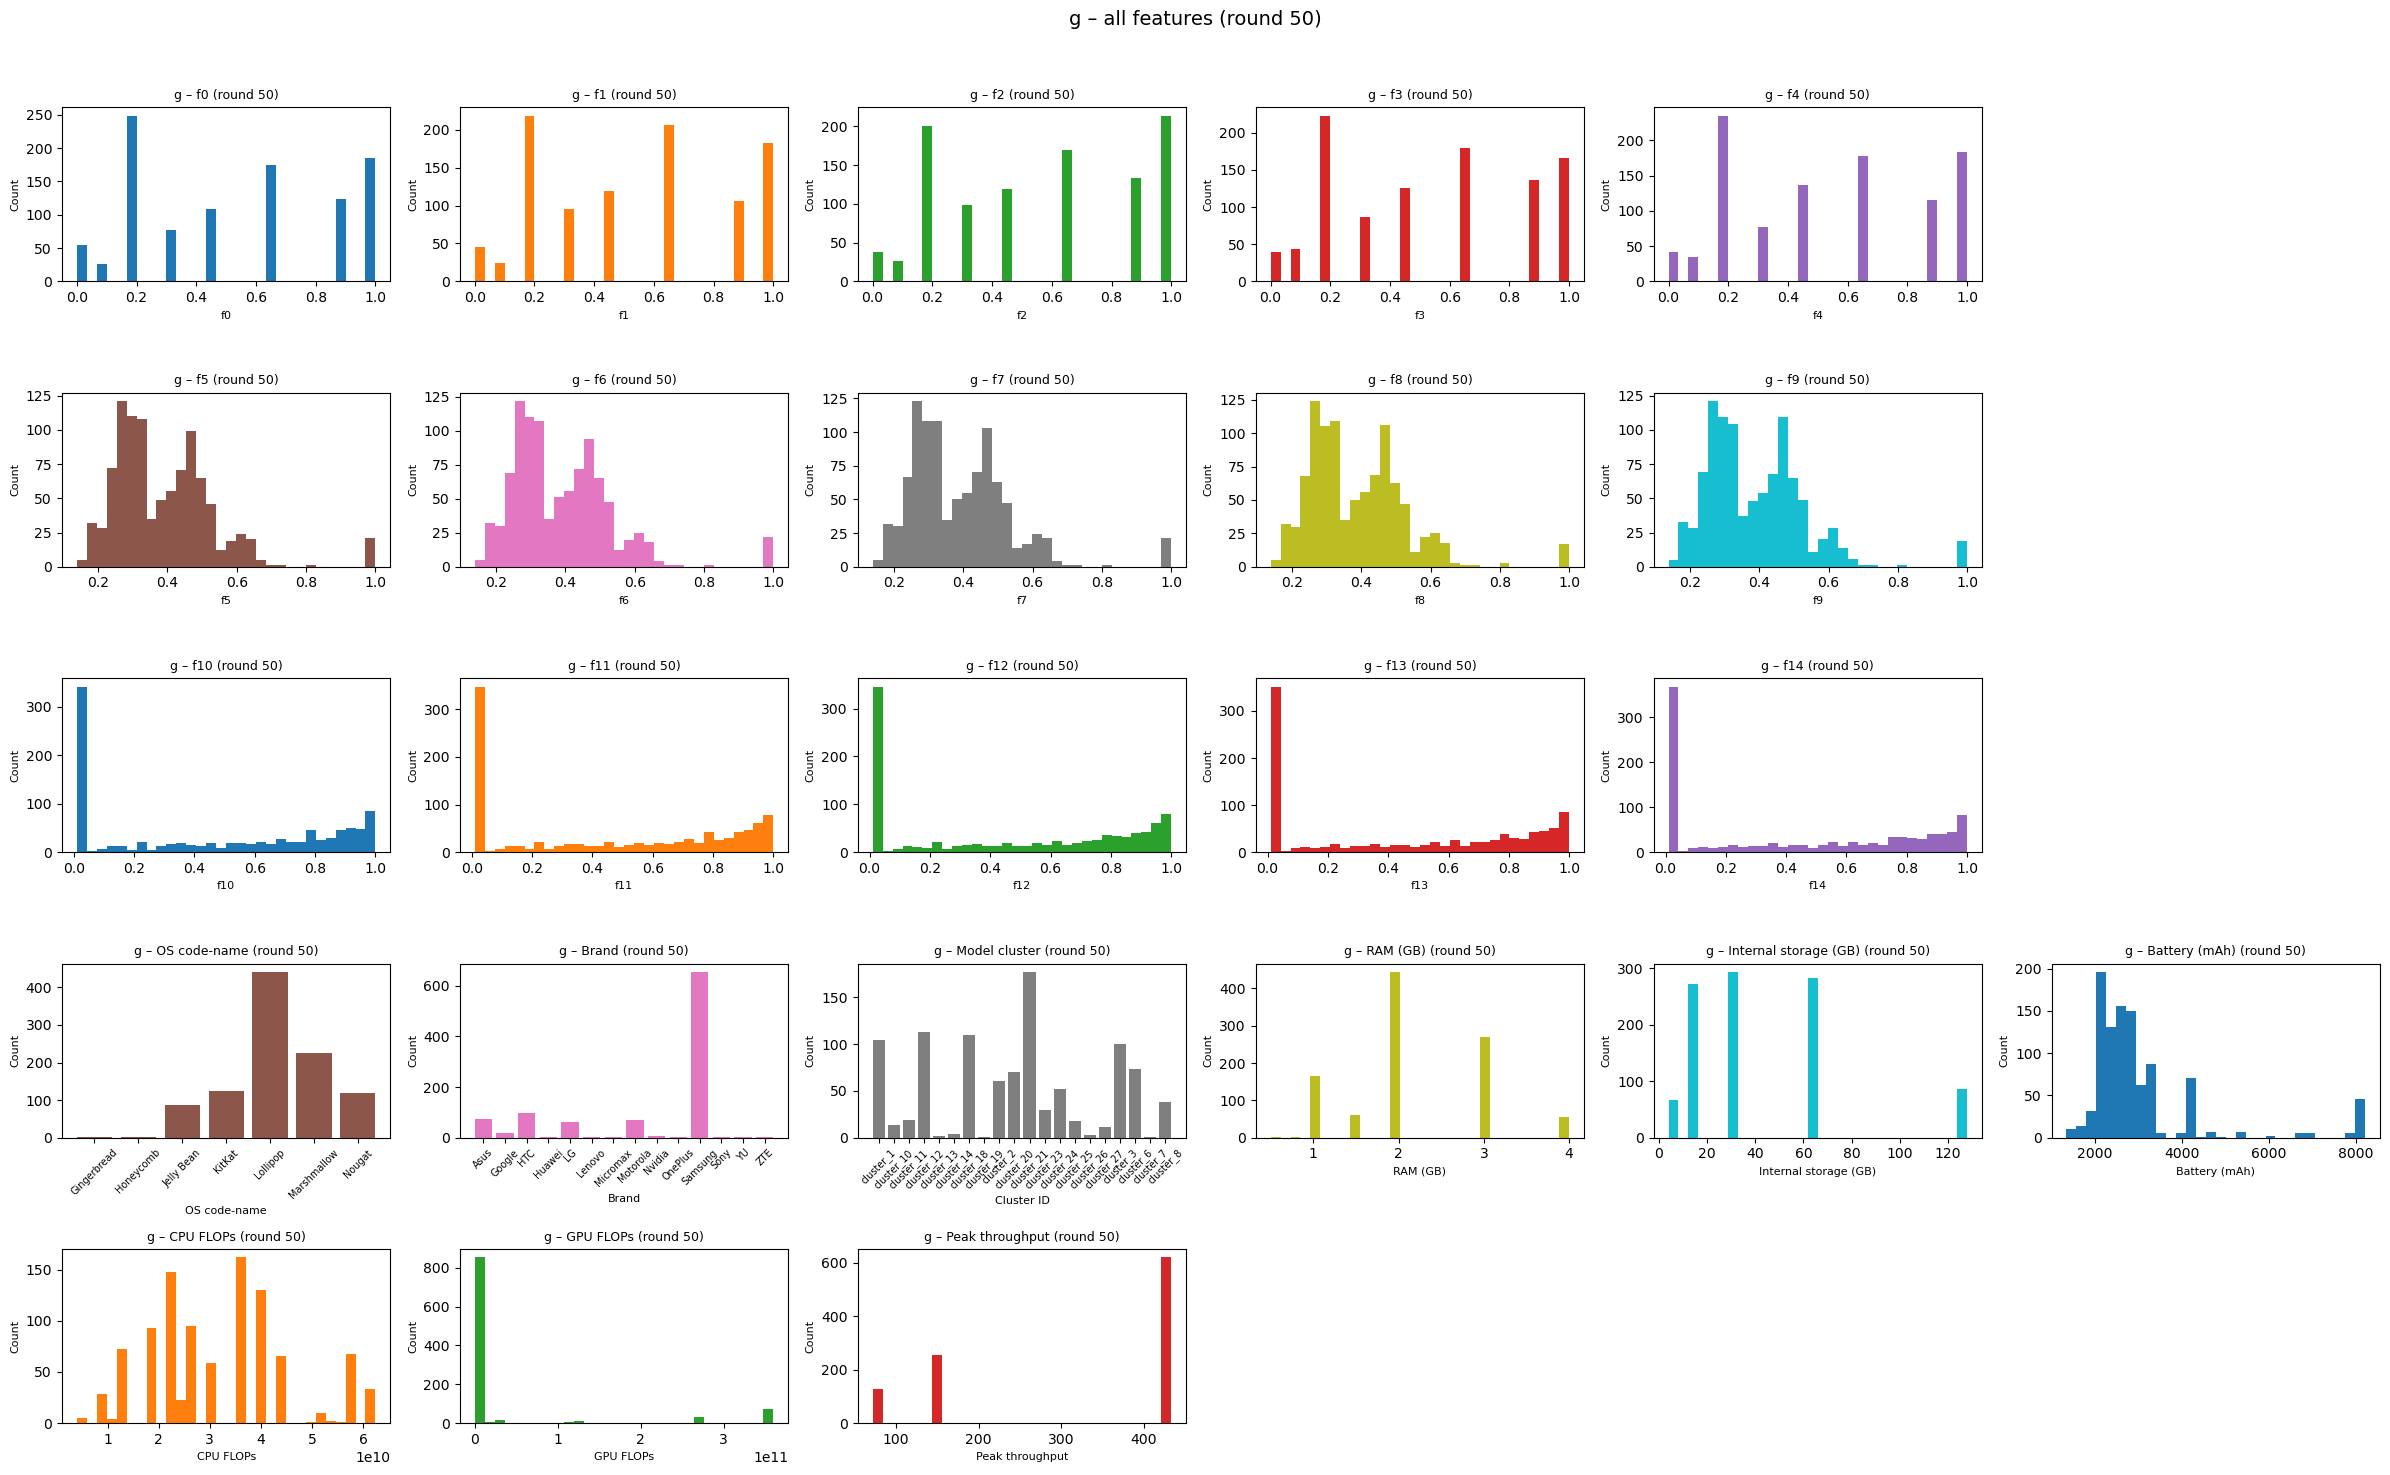

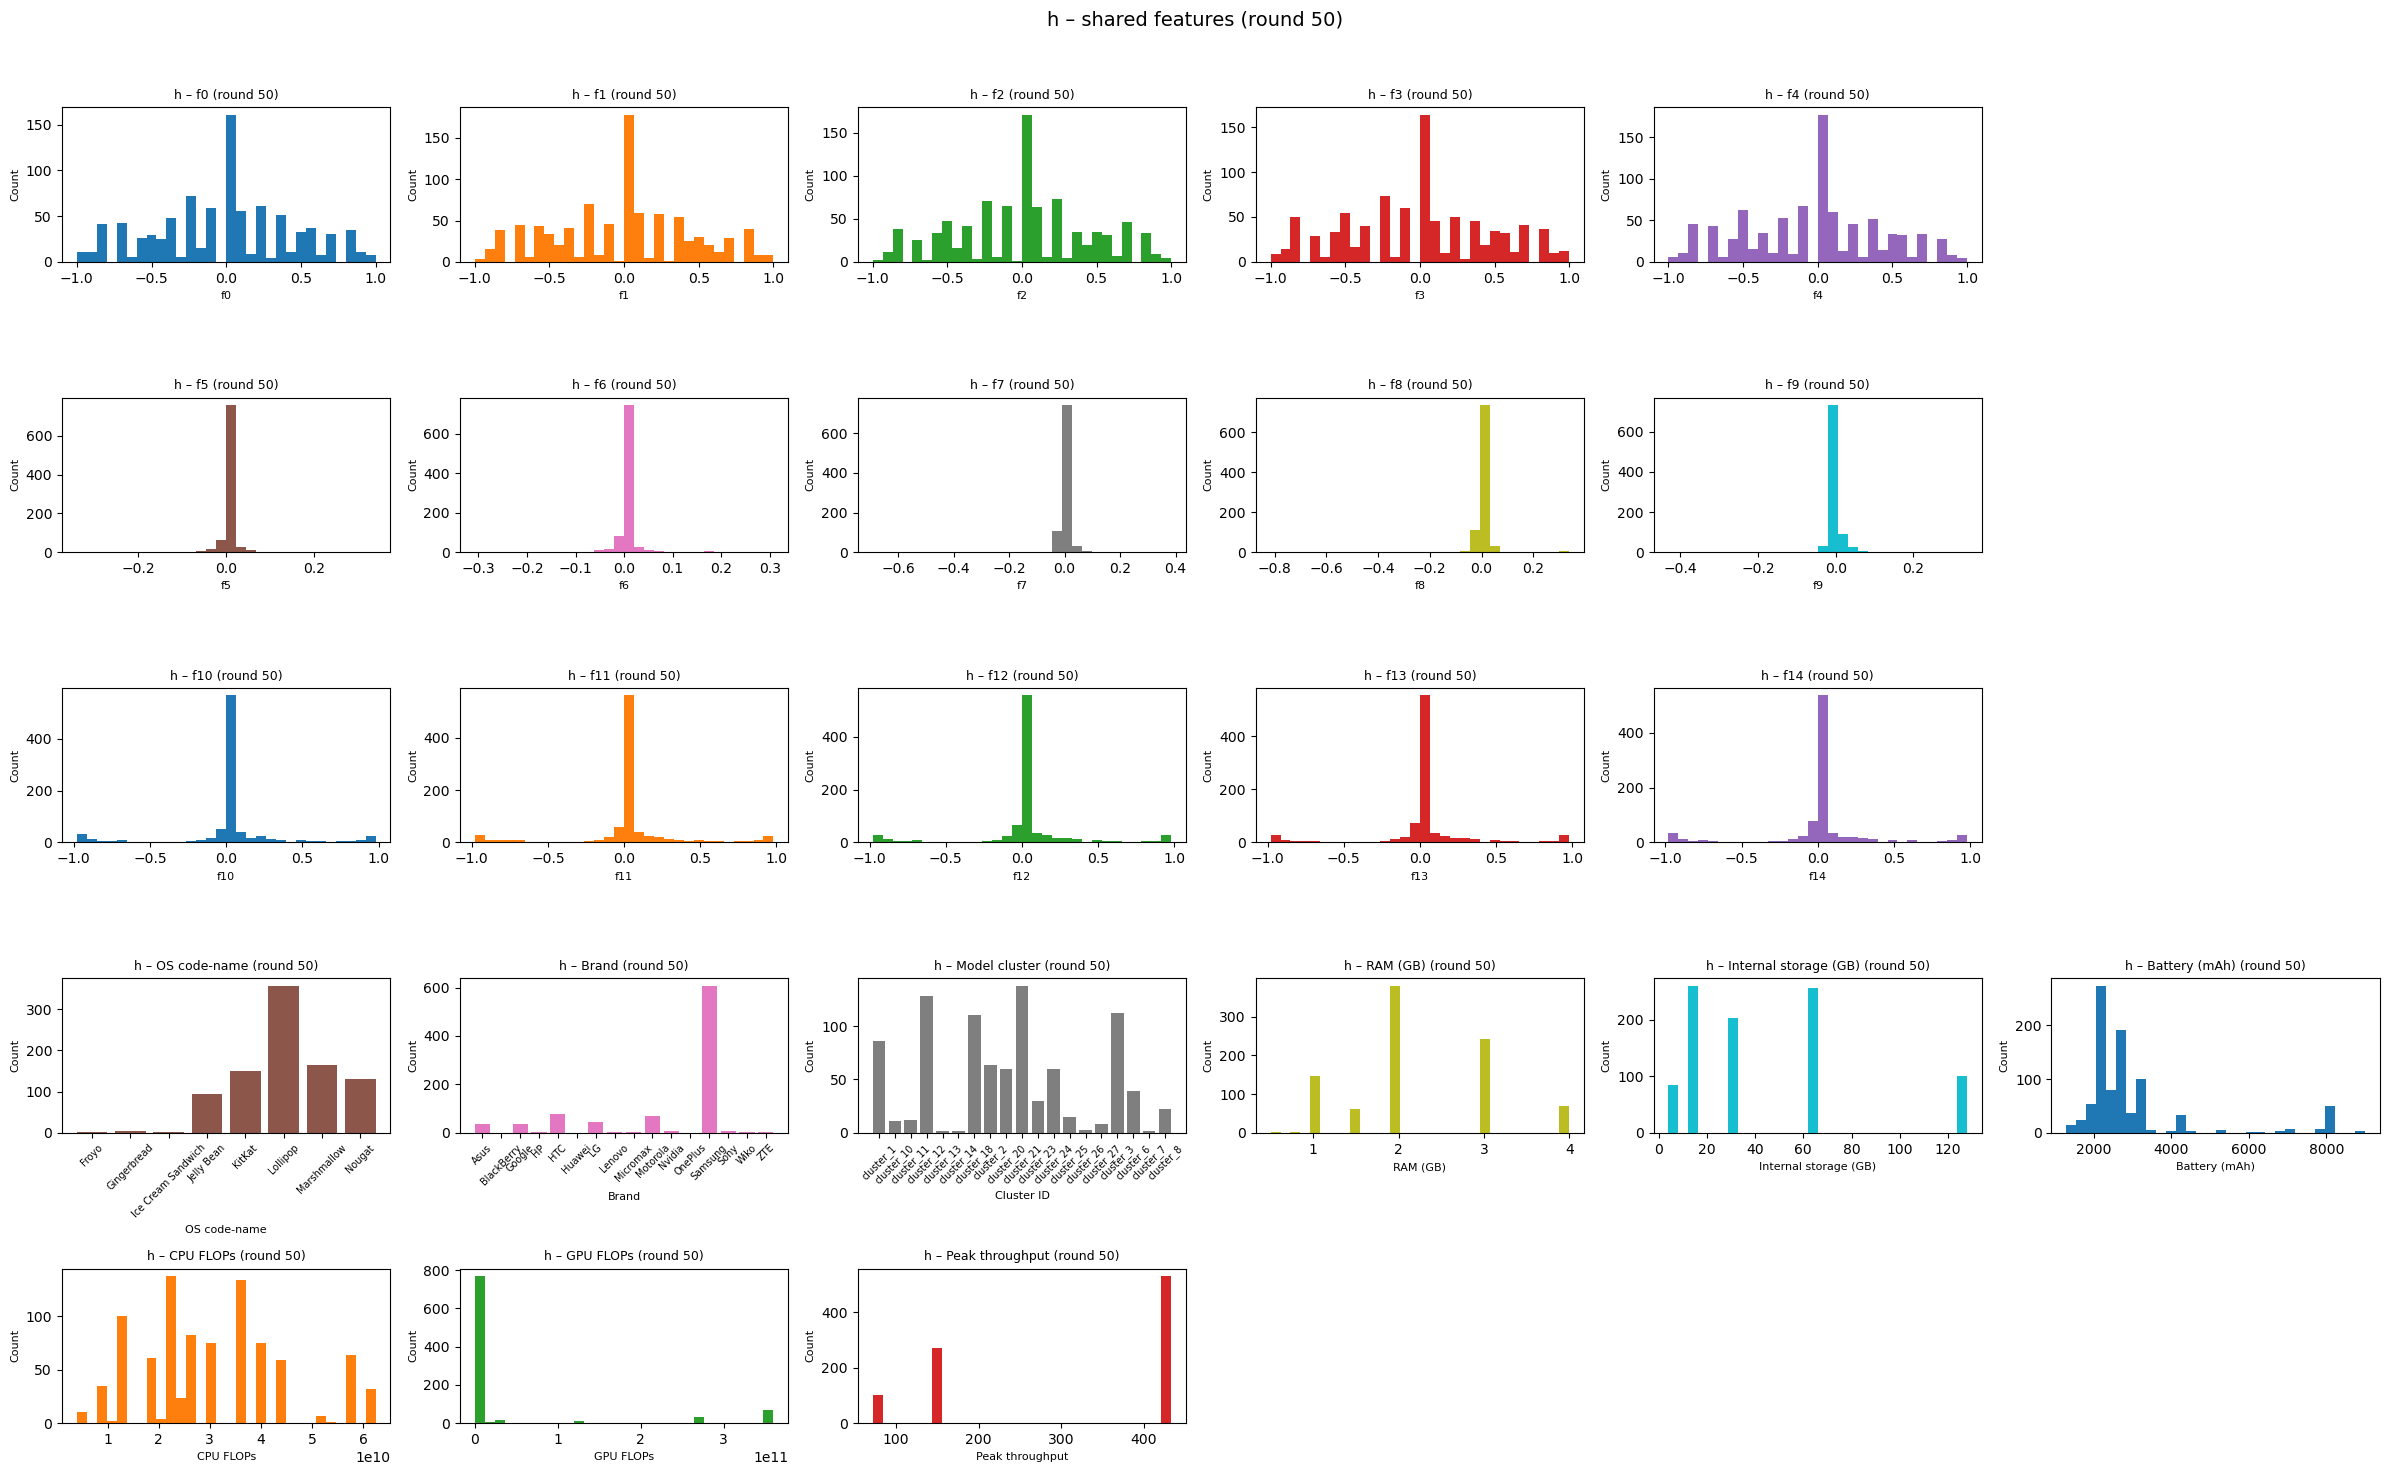

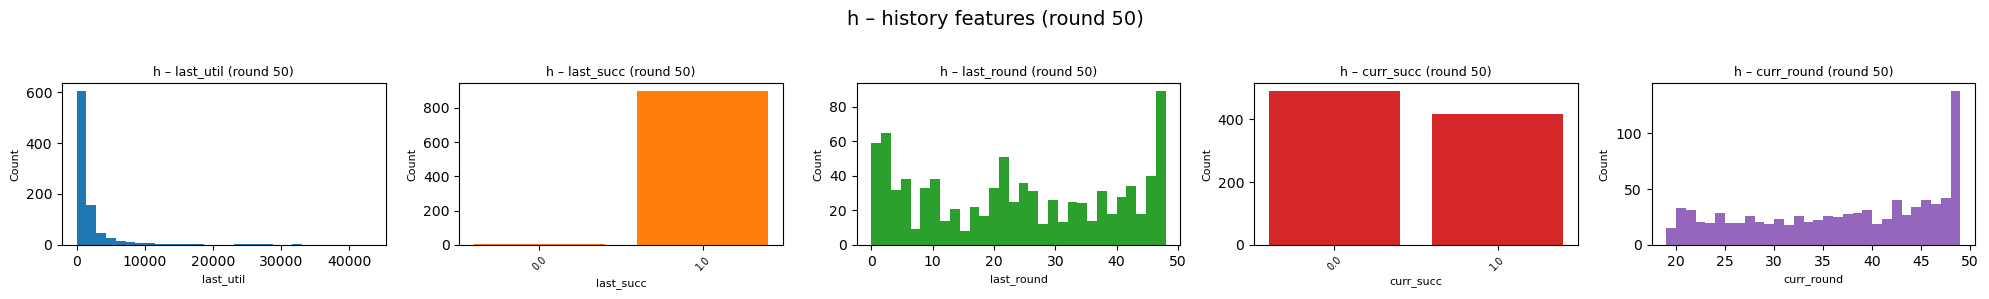

In [10]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Constants mirroring your encoders
# -----------------------------

OS_CODE_NAMES = [
    "Froyo", "Gingerbread", "Honeycomb", "Ice Cream Sandwich",
    "Jelly Bean", "KitKat", "Lollipop", "Marshmallow",
    "Nougat", "Oreo", "Pie",
]
LATEST_OS_RANK = len(OS_CODE_NAMES) - 1  # 10

BRANDS = [
    "Amazon", "LeEco", "YU", "Acer", "HP", "Samsung", "BQ", "Motorola",
    "Tesco", "Doogee", "iBall", "Asus", "Lenovo", "HTC", "LG", "Huawei",
    "Sony", "Silent Circle", "UMI", "Tecno", "Google", "OnePlus",
    "alcatel", "Wiko", "Nvidia", "Micromax", "ZTE", "BlackBerry",
]

# normalisation ranges used in the original encoder
RAM_MIN_GB, RAM_MAX_GB = 0.25, 4.0          # f72
INT_MIN_GB, INT_MAX_GB = 0.5, 128.0         # f73
BATT_MIN_MAH, BATT_MAX_MAH = 1300.0, 9600.0 # f74

CPU_MIN, CPU_MAX = 4_000_000_000, 67_200_000_000   # f75
GPU_MIN, GPU_MAX = 0, 360_000_000_000              # f76
THR_MIN, THR_MAX = 72, 433                         # f77

# indices for static encoded block f15..f77 (inclusive)
OS_START = 15        # f15, f16
OS_DIM = 2

BRAND_START = OS_START + OS_DIM         # f17..f44
BRAND_DIM = len(BRANDS)

# Model clusters: f45..f71 (27 dims)
CLUSTER_START = BRAND_START + BRAND_DIM

RAM_IDX = CLUSTER_START + 27            # f72
INT_MEM_IDX = RAM_IDX + 1               # f73
BATT_IDX = INT_MEM_IDX + 1              # f74
CPU_IDX = BATT_IDX + 1                  # f75
GPU_IDX = CPU_IDX + 1                   # f76
THR_IDX = GPU_IDX + 1                   # f77

# h-only extras
H_EXTRA_FEATURES = {
    78: "last_util",
    79: "last_succ",
    80: "last_round",
    81: "curr_succ",
    82: "curr_round",
}

# -----------------------------
# Decoding helpers
# -----------------------------

def decode_os_label(modernity: float, update_score: float) -> str:
    """Approximate the OS code-name from the encoded modernity/update_score."""
    eps = 1e-6
    if modernity < eps and update_score < eps:
        return "Unknown / non-Android"

    rank_float = modernity * LATEST_OS_RANK
    rank = int(round(rank_float))
    rank = max(0, min(rank, LATEST_OS_RANK))
    return OS_CODE_NAMES[rank]


def decode_ram_gb(ram_norm: float) -> float:
    return RAM_MIN_GB + ram_norm * (RAM_MAX_GB - RAM_MIN_GB)


def decode_internal_gb(int_norm: float) -> float:
    return INT_MIN_GB + int_norm * (INT_MAX_GB - INT_MIN_GB)


def decode_battery_mah(batt_norm: float) -> float:
    return BATT_MIN_MAH + batt_norm * (BATT_MAX_MAH - BATT_MIN_MAH)


def decode_cpu(cpu_norm: float) -> float:
    return CPU_MIN + cpu_norm * (CPU_MAX - CPU_MIN)


def decode_gpu(gpu_norm: float) -> float:
    return GPU_MIN + gpu_norm * (GPU_MAX - GPU_MIN)


def decode_thr(thr_norm: float) -> float:
    return THR_MIN + thr_norm * (THR_MAX - THR_MIN)


def load_cluster_labels(clusters_json_path: Path) -> list[str]:
    """
    Read clusters.json and return labels in the same order as the encoder:
    index 0 corresponds to clusters_json[0], etc.
    """
    with clusters_json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    # Use the "id" as the human-readable label
    return [str(obj["id"]) for obj in data]


# -----------------------------
# Grid layout config
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 24 plots arranged as:
# 5, 5, 5, 6, 3
ROW_LENGTHS = [5, 5, 5, 6, 3]


def collect_shared_specs(df_round: pd.DataFrame,
                         prefix: str,
                         round_i: int,
                         cluster_labels: list[str]) -> list[dict]:
    """
    Collect plot specs for the 24 shared features:
    f0–f14, OS, brand, cluster, RAM, internal, battery, CPU, GPU, throughput.
    Each spec: {"kind": "hist"/"bar", "data": ..., "title": ..., "xlabel": ...}
    """
    specs: list[dict] = []

    # -------------------------
    # Base 15 features f0..f14
    # -------------------------
    for idx in range(15):
        fname = f"f{idx}"
        if fname not in df_round.columns:
            continue
        specs.append({
            "kind": "hist",
            "data": df_round[fname].astype(float),
            "title": f"{prefix} – {fname} (round {round_i})",
            "xlabel": fname,
        })

    # -------------------------
    # OS (f15, f16) → categorical OS code-name
    # -------------------------
    if {"f15", "f16"}.issubset(df_round.columns):
        modernity = df_round["f15"].astype(float).values
        update_score = df_round["f16"].astype(float).values
        os_labels = [
            decode_os_label(m, u) for m, u in zip(modernity, update_score)
        ]
        specs.append({
            "kind": "bar",
            "data": os_labels,
            "title": f"{prefix} – OS code-name (round {round_i})",
            "xlabel": "OS code-name",
        })

    # -------------------------
    # Brand (f17..f44) one-hot
    # -------------------------
    brand_cols = [f"f{BRAND_START + i}" for i in range(len(BRANDS))]
    if all(c in df_round.columns for c in brand_cols):
        brand_mat = df_round[brand_cols].values.astype(float)
        max_vals = brand_mat.max(axis=1)
        idxs = brand_mat.argmax(axis=1)
        labels = []
        for max_val, idx in zip(max_vals, idxs):
            if max_val <= 0:
                labels.append("Unknown")
            else:
                labels.append(BRANDS[idx])
        specs.append({
            "kind": "bar",
            "data": labels,
            "title": f"{prefix} – Brand (round {round_i})",
            "xlabel": "Brand",
        })

    # -------------------------
    # Model cluster (f45..f71) one-hot
    # -------------------------
    cluster_cols = [f"f{CLUSTER_START + i}" for i in range(len(cluster_labels))]
    if all(c in df_round.columns for c in cluster_cols):
        cl_mat = df_round[cluster_cols].values.astype(float)
        max_vals = cl_mat.max(axis=1)
        idxs = cl_mat.argmax(axis=1)
        labels = []
        for max_val, idx in zip(max_vals, idxs):
            if max_val <= 0:
                labels.append("Unknown")
            else:
                labels.append(f"cluster_{cluster_labels[idx]}")
        specs.append({
            "kind": "bar",
            "data": labels,
            "title": f"{prefix} – Model cluster (round {round_i})",
            "xlabel": "Cluster ID",
        })

    # -------------------------
    # HW: RAM, internal, battery, CPU, GPU, throughput
    #   RAM: f72, internal: f73, batt: f74, CPU: f75, GPU: f76, thr: f77
    # -------------------------
    cols_needed = [f"f{i}" for i in range(RAM_IDX, THR_IDX + 1)]
    if all(c in df_round.columns for c in cols_needed):
        ram_gb = decode_ram_gb(df_round[f"f{RAM_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": ram_gb,
            "title": f"{prefix} – RAM (GB) (round {round_i})",
            "xlabel": "RAM (GB)",
        })

        int_gb = decode_internal_gb(df_round[f"f{INT_MEM_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": int_gb,
            "title": f"{prefix} – Internal storage (GB) (round {round_i})",
            "xlabel": "Internal storage (GB)",
        })

        batt_mah = decode_battery_mah(df_round[f"f{BATT_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": batt_mah,
            "title": f"{prefix} – Battery (mAh) (round {round_i})",
            "xlabel": "Battery (mAh)",
        })

        cpu_val = decode_cpu(df_round[f"f{CPU_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": cpu_val,
            "title": f"{prefix} – CPU FLOPs (round {round_i})",
            "xlabel": "CPU FLOPs",
        })

        gpu_val = decode_gpu(df_round[f"f{GPU_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": gpu_val,
            "title": f"{prefix} – GPU FLOPs (round {round_i})",
            "xlabel": "GPU FLOPs",
        })

        thr_val = decode_thr(df_round[f"f{THR_IDX}"].astype(float))
        specs.append({
            "kind": "hist",
            "data": thr_val,
            "title": f"{prefix} – Peak throughput (round {round_i})",
            "xlabel": "Peak throughput",
        })

    return specs


def collect_h_specs(h_round: pd.DataFrame,
                    round_i: int,
                    cluster_labels: list[str]):
    """
    For h: return (shared_specs, extra_specs) where extra_specs are
    last_util, last_succ, last_round, curr_succ, curr_round.
    """
    shared_specs = collect_shared_specs(h_round, "h", round_i, cluster_labels)
    extra_specs: list[dict] = []

    for idx, name in H_EXTRA_FEATURES.items():
        col = f"f{idx}"
        if col not in h_round.columns:
            continue
        s = h_round[col].astype(float)
        unique_vals = sorted(s.dropna().unique())
        if set(unique_vals).issubset({0.0, 1.0}) and len(unique_vals) <= 2:
            kind = "bar"
        else:
            kind = "hist"

        extra_specs.append({
            "kind": kind,
            "data": s,
            "title": f"h – {name} (round {round_i})",
            "xlabel": name,
        })

    return shared_specs, extra_specs


def _plot_specs_grid(specs: list[dict],
                     title: str,
                     row_lengths: list[int],
                     colors: list[str]):
    """
    Plot specs in a 5-row grid with given row_lengths (e.g. [5,5,5,6,3]).
    Uses a different color per plot, taken from `colors`.
    """
    if not specs:
        print(f"[WARN] no specs to plot for {title}")
        return

    n_rows = len(row_lengths)
    n_cols = max(row_lengths)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols * 4, n_rows * 3))
    axes = np.array(axes)

    if axes.ndim == 1:  # safety for degenerate shapes
        axes = axes.reshape(n_rows, n_cols)

    spec_idx = 0
    total_slots = sum(row_lengths)

    for r in range(n_rows):
        for c in range(row_lengths[r]):
            ax = axes[r, c]
            if spec_idx >= len(specs) or spec_idx >= total_slots:
                ax.axis("off")
                continue

            spec = specs[spec_idx]
            series = pd.Series(spec["data"]).dropna()
            if series.empty:
                ax.axis("off")
                spec_idx += 1
                continue

            color = colors[spec_idx % len(colors)]

            if spec["kind"] == "hist":
                ax.hist(series, bins=30, color=color)
            else:  # "bar"
                counts = series.value_counts().sort_index()
                ax.bar(counts.index.astype(str), counts.values, color=color)
                ax.tick_params(axis="x", rotation=45, labelsize=7)

            ax.set_title(spec["title"], fontsize=9)
            ax.set_xlabel(spec.get("xlabel", ""), fontsize=8)
            ax.set_ylabel("Count", fontsize=8)
            spec_idx += 1

        # turn off unused columns on this row
        for c in range(row_lengths[r], n_cols):
            axes[r, c].axis("off")

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])


def _plot_specs_row(specs: list[dict],
                    title: str,
                    colors: list[str]):
    """
    Plot a single row of N specs (used for the 5 extra h plots),
    using a different color per plot from `colors`.
    """
    if not specs:
        print(f"[WARN] no extra specs to plot for {title}")
        return

    n = len(specs)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3))
    if n == 1:
        axes = [axes]

    for i, spec in enumerate(specs):
        ax = axes[i]
        series = pd.Series(spec["data"]).dropna()
        color = colors[i % len(colors)]

        if spec["kind"] == "hist":
            ax.hist(series, bins=30, color=color)
        else:
            counts = series.value_counts().sort_index()
            ax.bar(counts.index.astype(str), counts.values, color=color)
            ax.tick_params(axis="x", rotation=45, labelsize=7)

        ax.set_title(spec["title"], fontsize=9)
        ax.set_xlabel(spec.get("xlabel", ""), fontsize=8)
        ax.set_ylabel("Count", fontsize=8)

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])


# -----------------------------
# Main function (same name as before)
# -----------------------------
def plot_round_distributions(
    round_i: int,
    g_csv_path: Path,
    h_csv_path: Path,
    clusters_json_path: Path,
):
    # --- load data ---
    g_df = pd.read_csv(g_csv_path)
    h_df = pd.read_csv(h_csv_path)

    # Filter by round
    g_round = g_df[g_df["round"] == round_i].copy()
    h_round = h_df[h_df["round"] == round_i].copy()

    if g_round.empty:
        print(f"[WARN] No rows in g for round {round_i}")
    if h_round.empty:
        print(f"[WARN] No rows in h for round {round_i}")

    # Load cluster labels
    cluster_labels = load_cluster_labels(clusters_json_path)
    n_clusters = len(cluster_labels)
    assert n_clusters == 27, f"Expected 27 clusters, got {n_clusters}"

    # Use Matplotlib's default color cycle
    base_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # -------------------------
    # g: one big grid of up to 24 shared plots
    # -------------------------
    g_specs = collect_shared_specs(g_round, "g", round_i, cluster_labels)
    g_colors = [base_colors[i % len(base_colors)] for i in range(len(g_specs))]

    _plot_specs_grid(
        g_specs,
        title=f"g – all features (round {round_i})",
        row_lengths=ROW_LENGTHS,
        colors=g_colors,
    )

    # -------------------------
    # h: one big grid for shared plots + one row for the 5 extra
    # -------------------------
    h_shared_specs, h_extra_specs = collect_h_specs(h_round, round_i, cluster_labels)
    h_colors = [base_colors[i % len(base_colors)] for i in range(len(h_shared_specs))]
    _plot_specs_grid(
        h_shared_specs,
        title=f"h – shared features (round {round_i})",
        row_lengths=ROW_LENGTHS,
        colors=h_colors,
    )

    # extra 5 plots (last_*/curr_*)
    h_extra_colors = [base_colors[i % len(base_colors)] for i in range(len(h_extra_specs))]
    _plot_specs_row(
        h_extra_specs,
        title=f"h – history features (round {round_i})",
        colors=h_extra_colors,
    )


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # TODO: replace these with your actual file names
    base_dir = Path("datasets/openimage_bliss")

    g_csv = sorted(base_dir.glob("g_*.csv"))[-1]
    h_csv = sorted(base_dir.glob("h_*.csv"))[-1]
    clusters_json = Path("../clusters.json")

    round_i = 50

    plot_round_distributions(
        round_i=round_i,
        g_csv_path=g_csv,
        h_csv_path=h_csv,
        clusters_json_path=clusters_json,
    )

    # Show all figures at the end
    plt.show()

/tmp/ipykernel_1244164/1222048836.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Done plotting all distributions for round 50


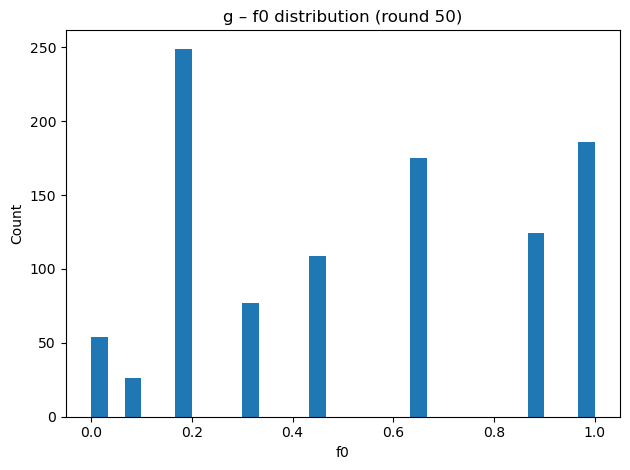

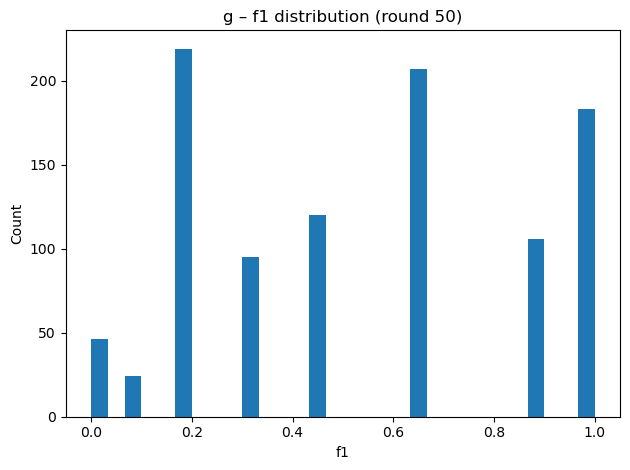

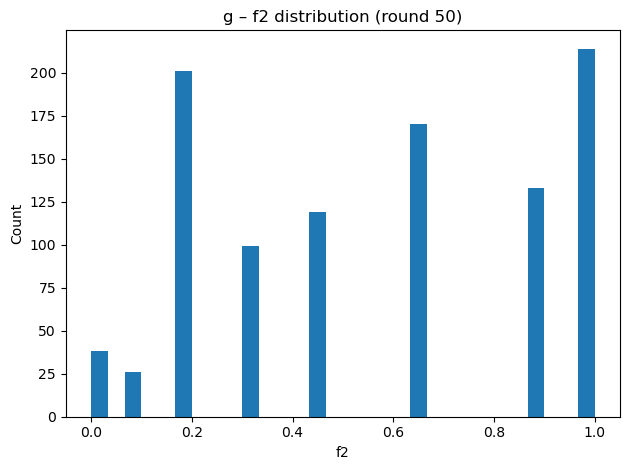

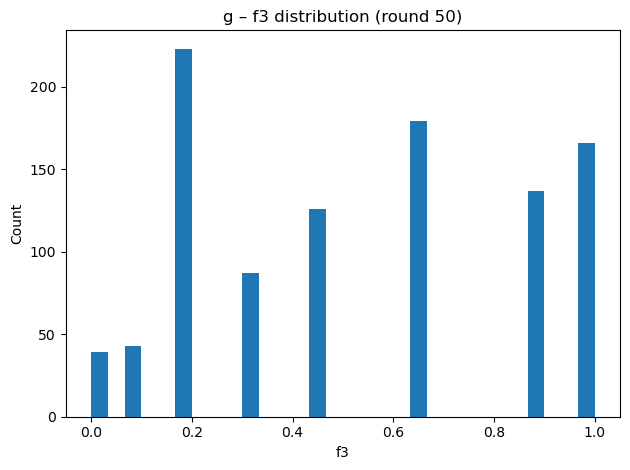

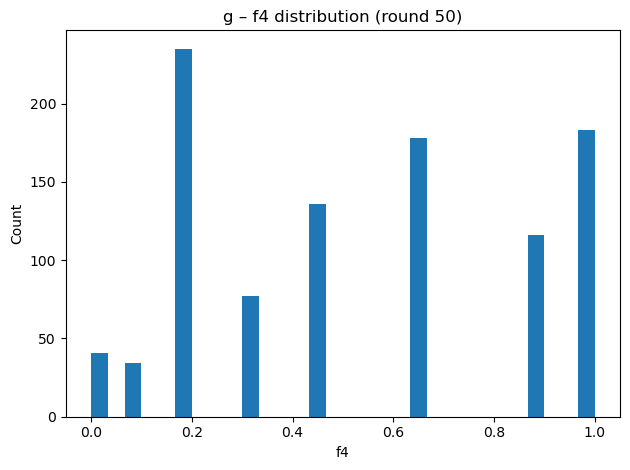

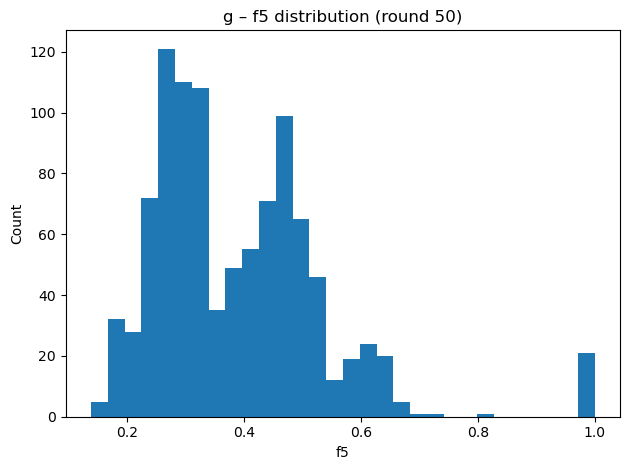

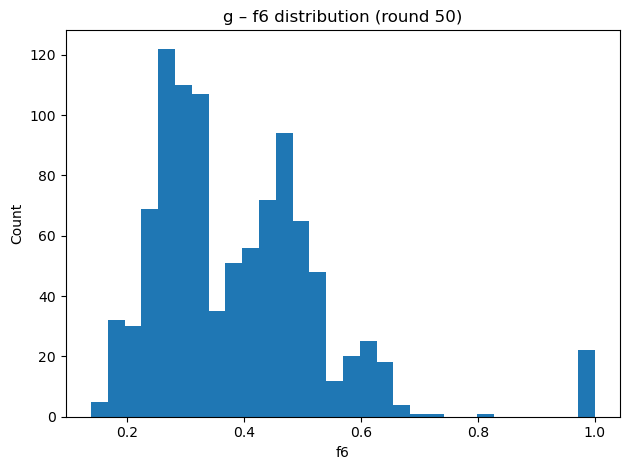

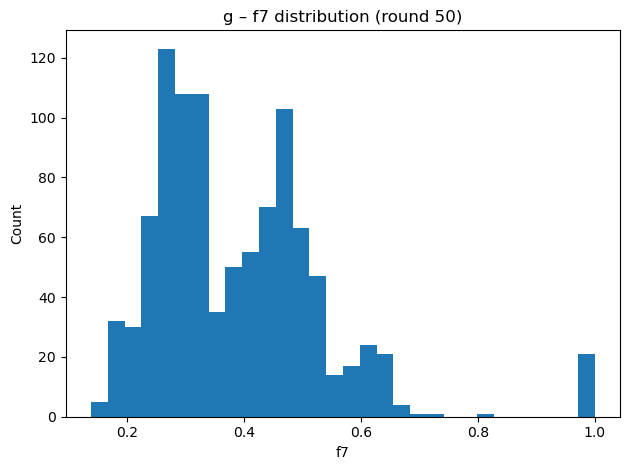

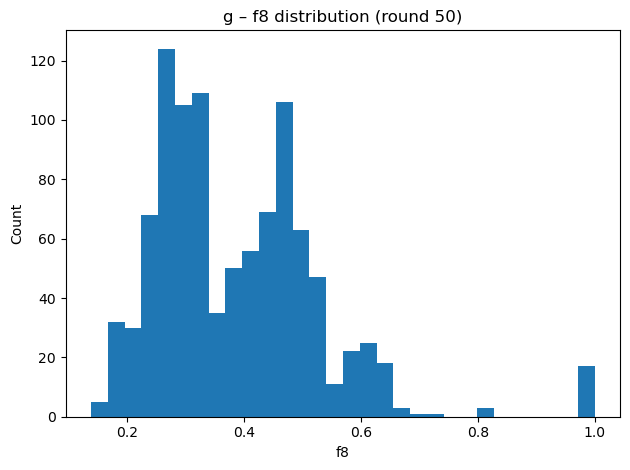

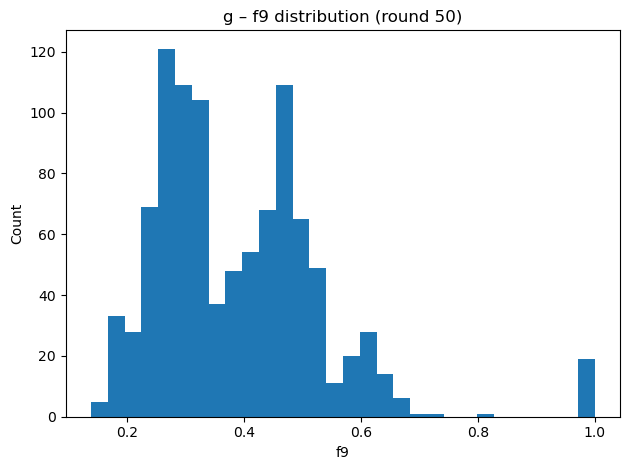

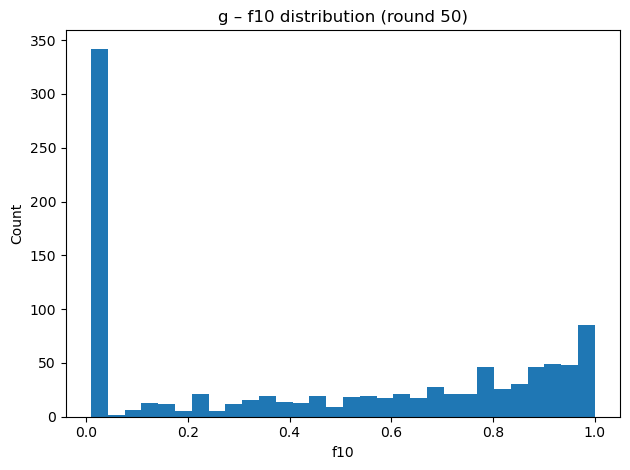

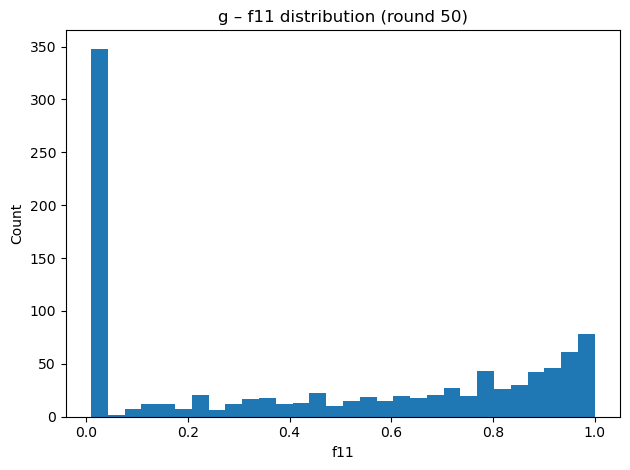

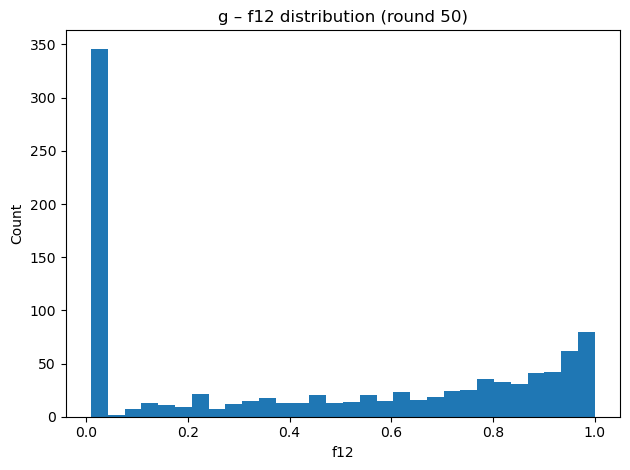

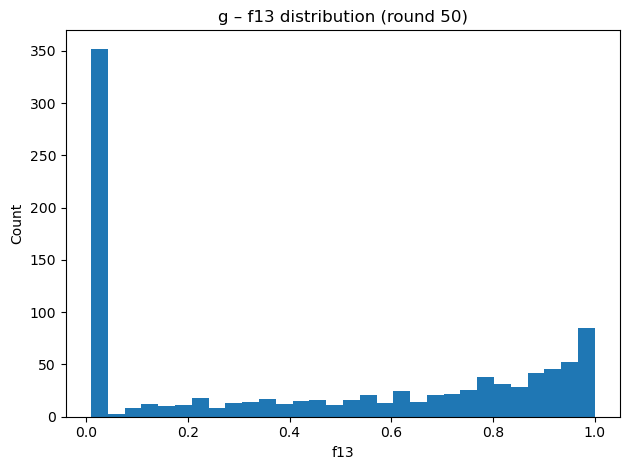

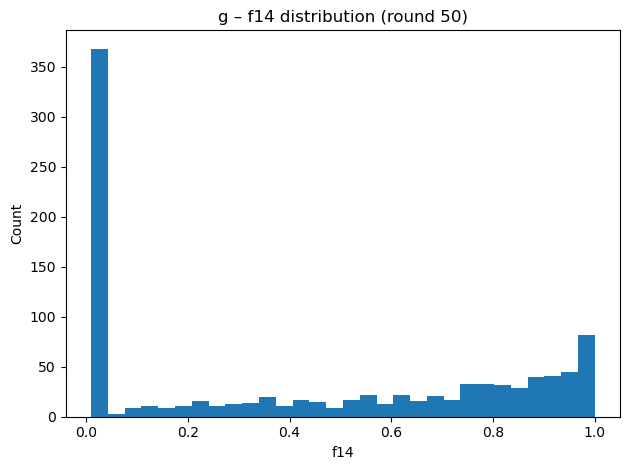

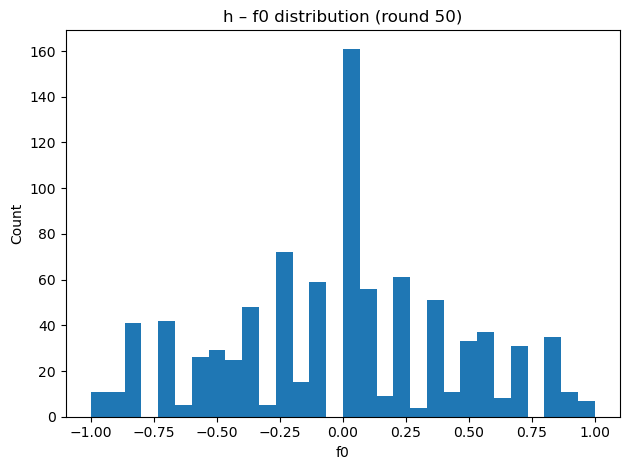

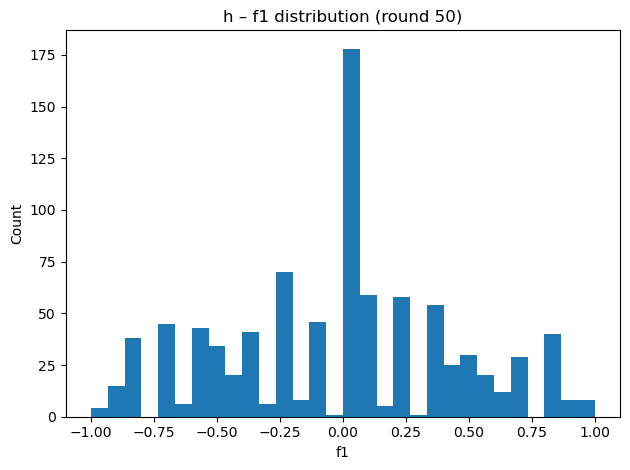

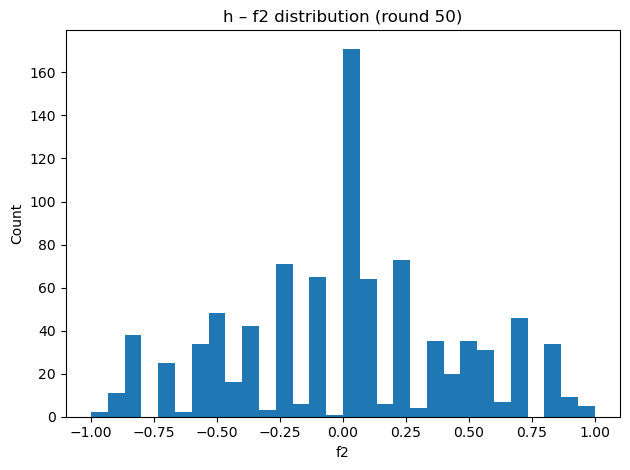

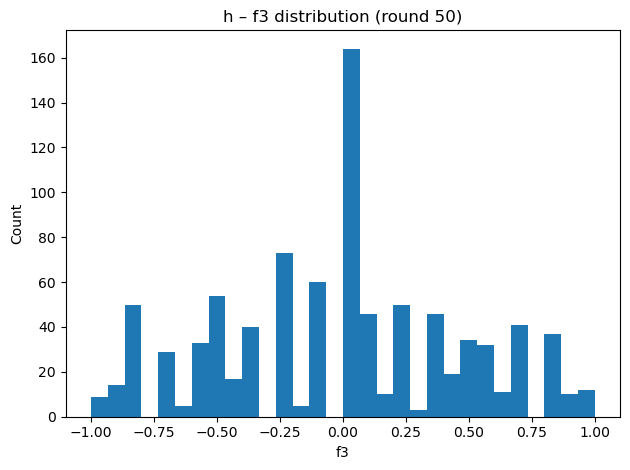

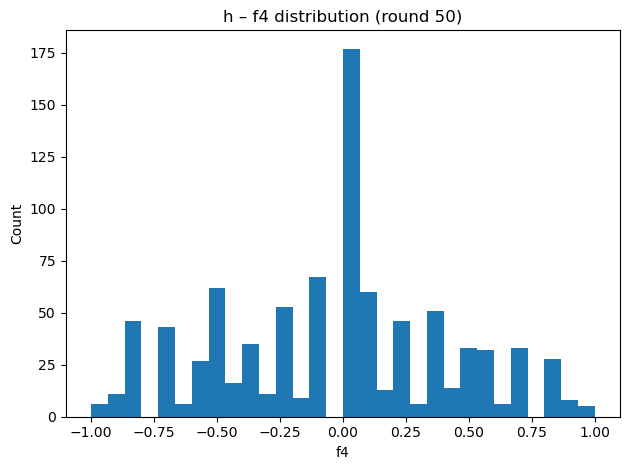

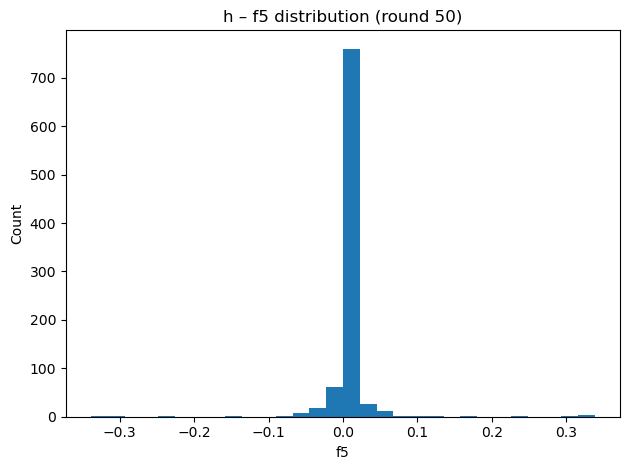

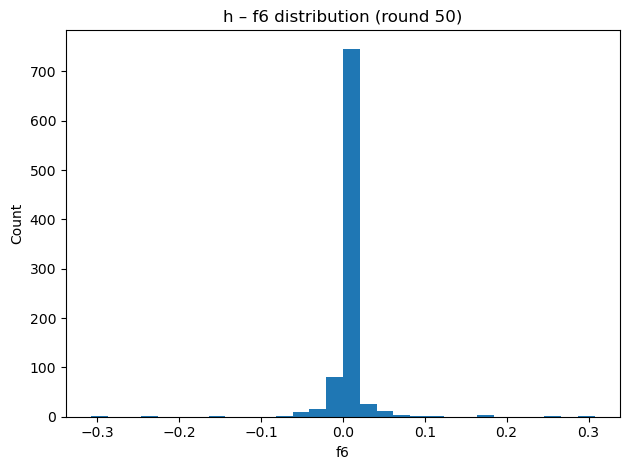

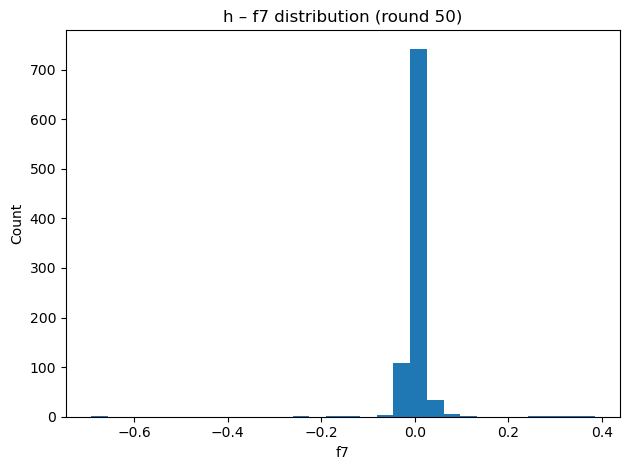

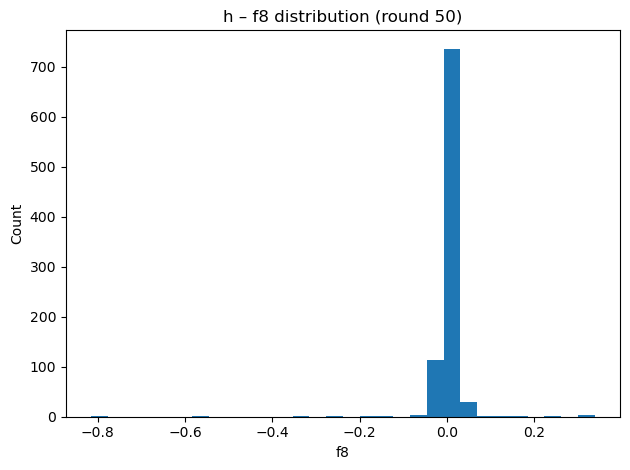

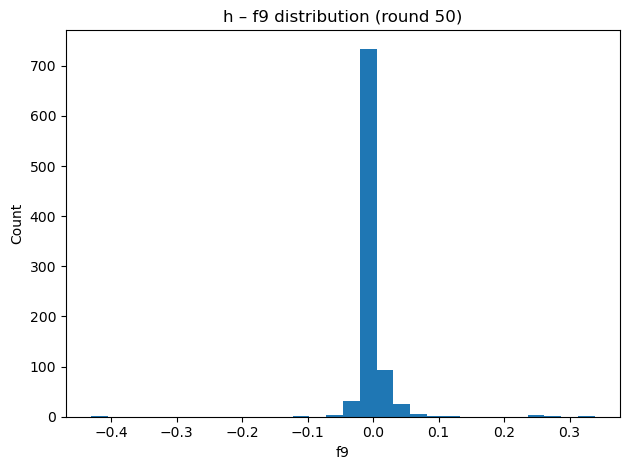

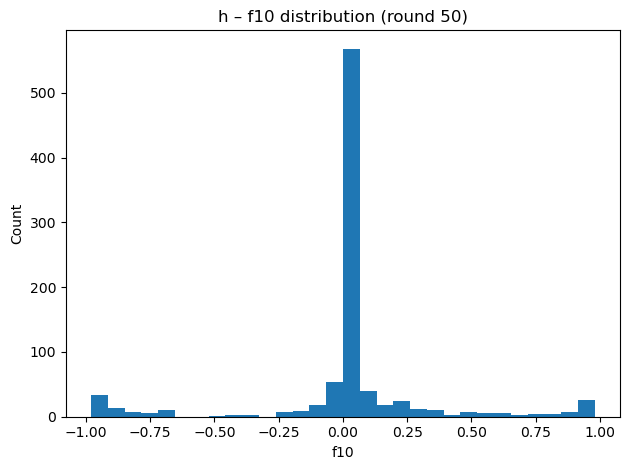

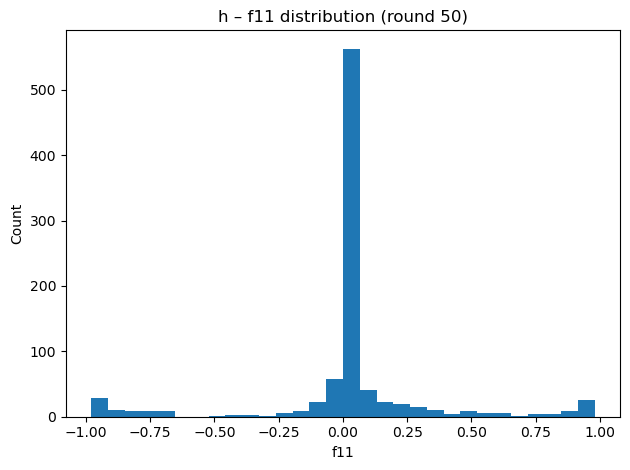

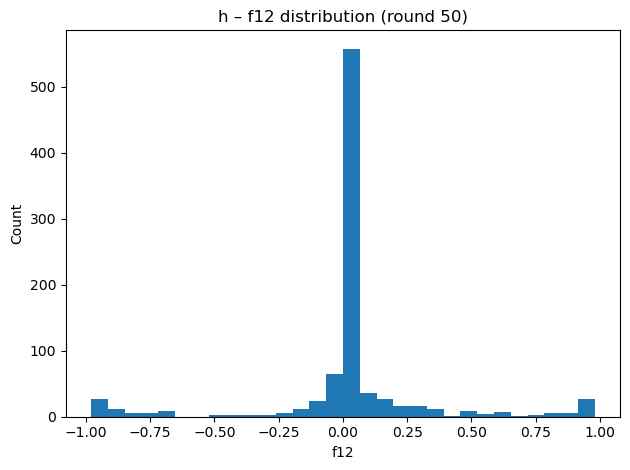

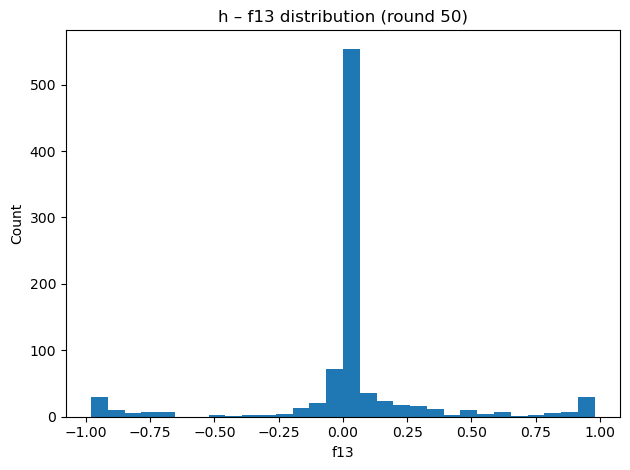

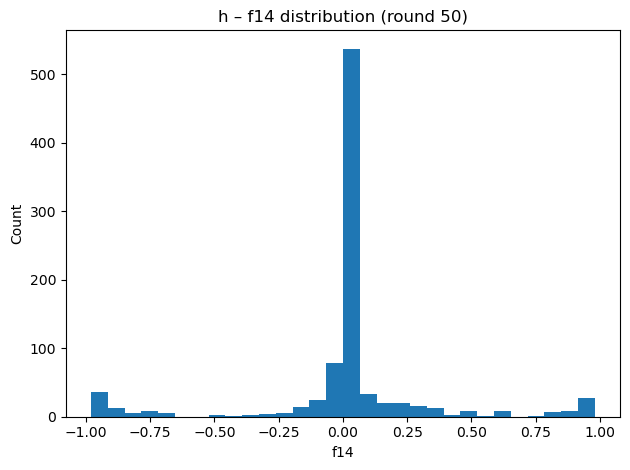

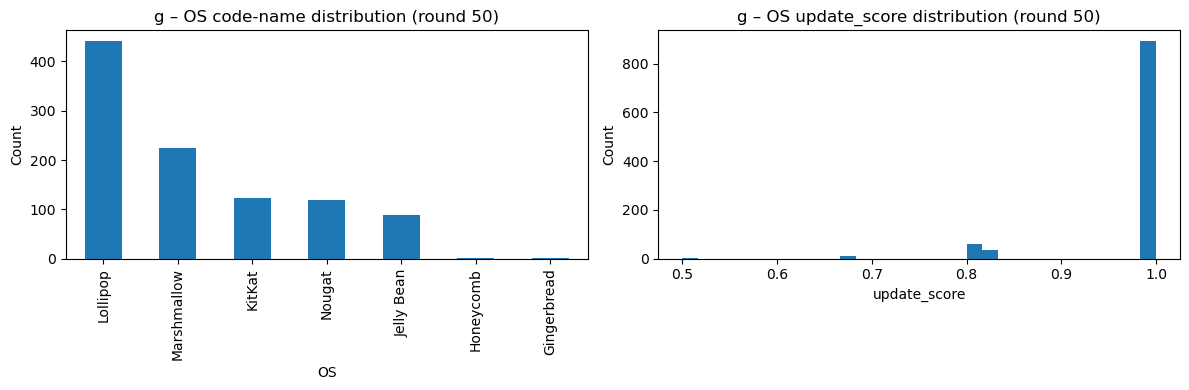

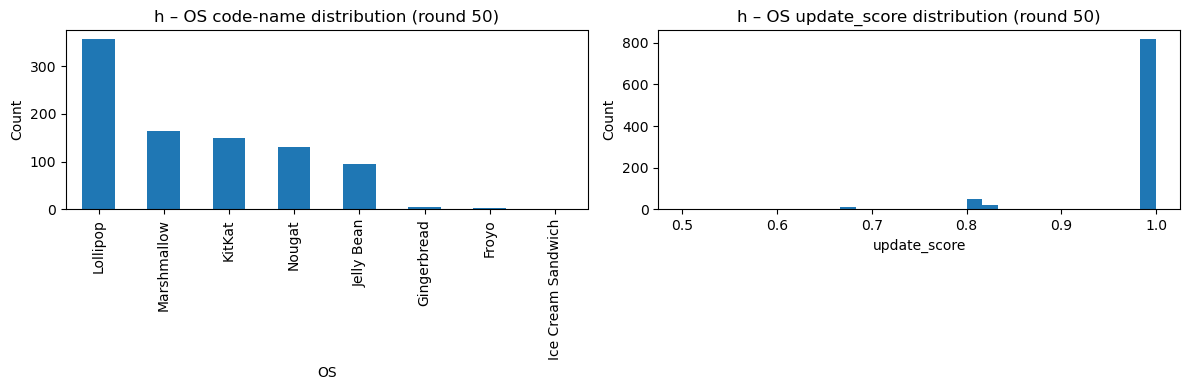

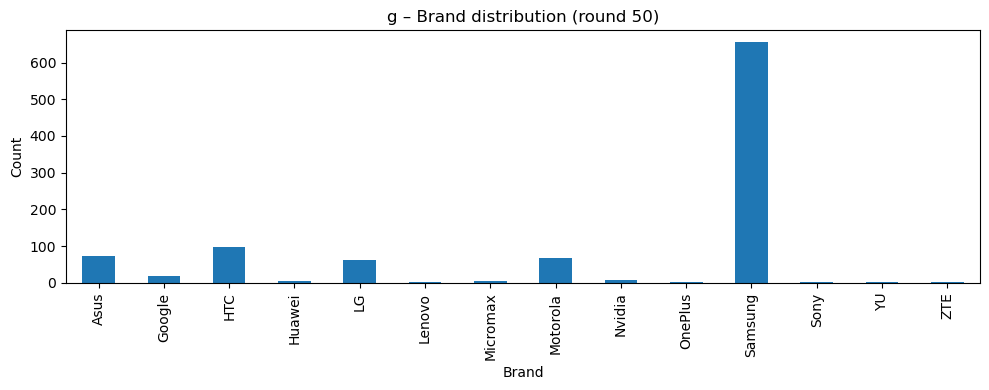

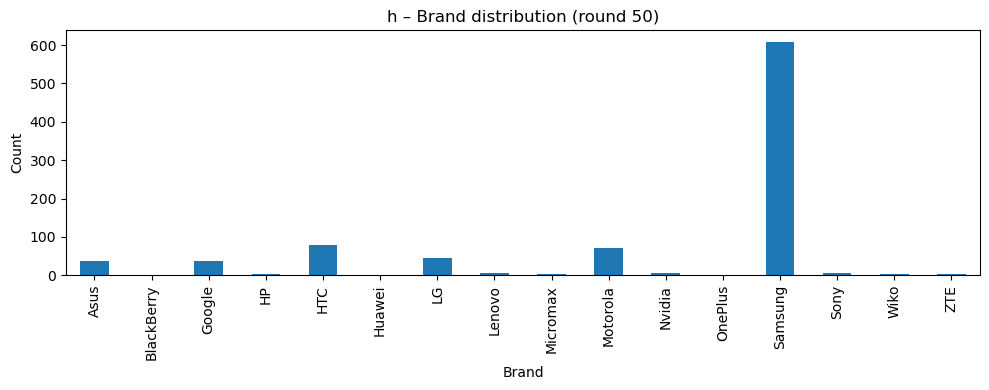

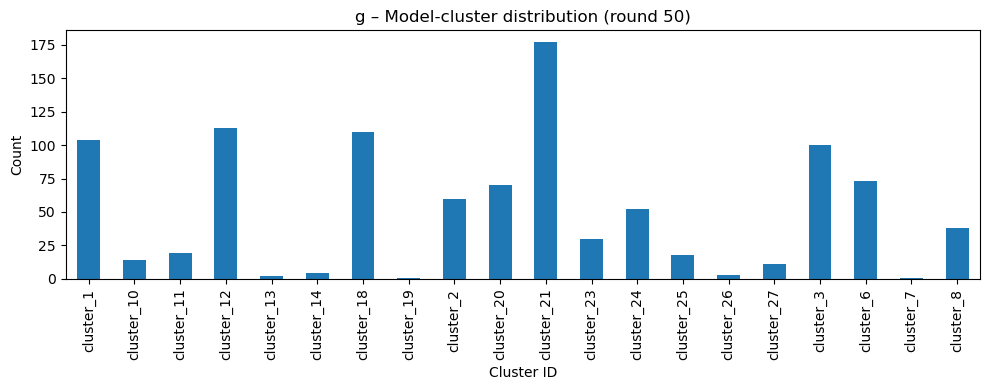

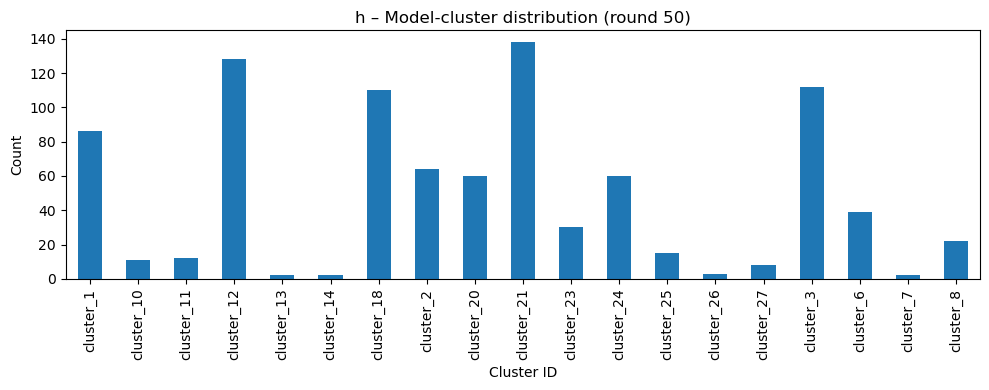

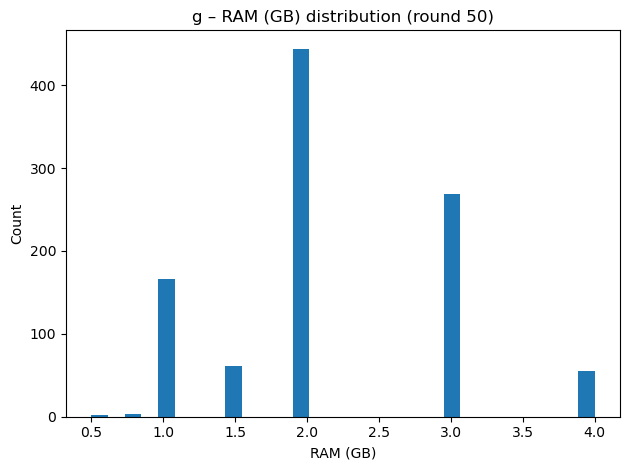

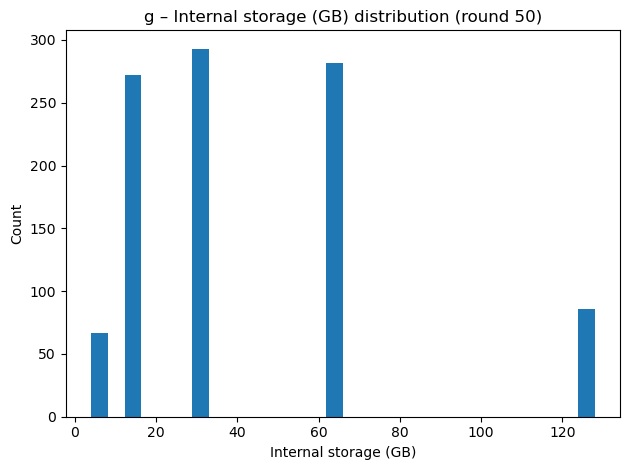

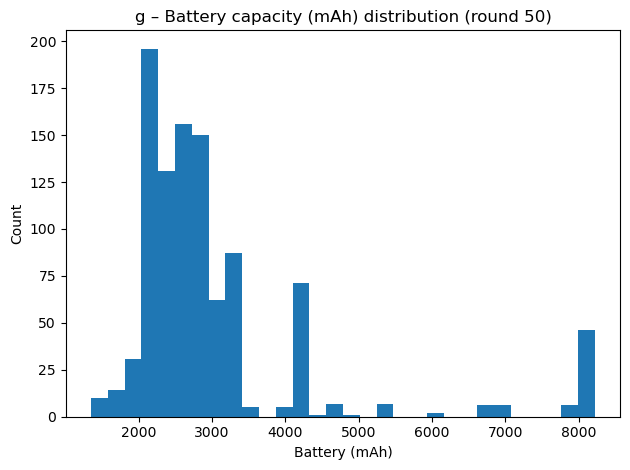

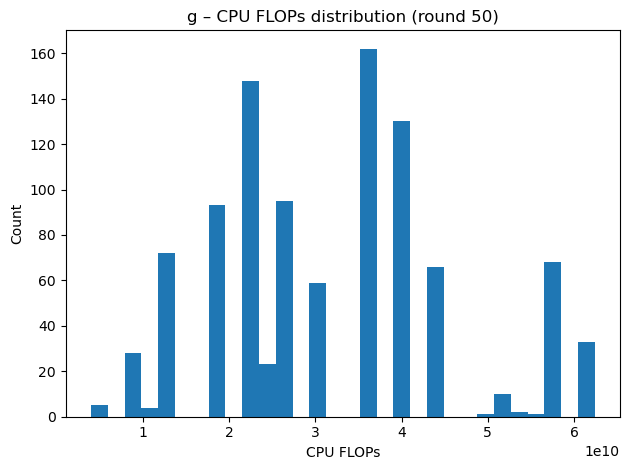

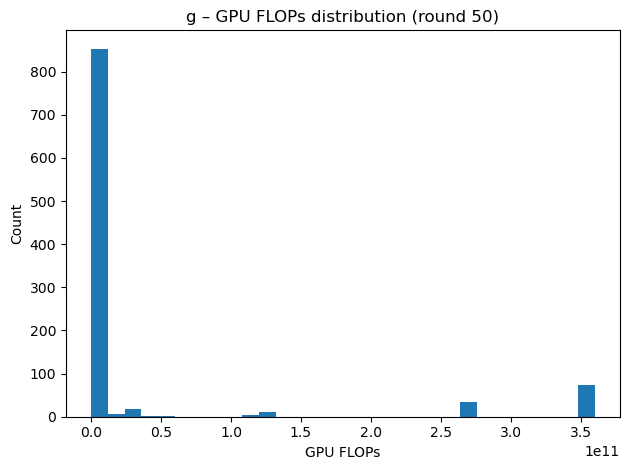

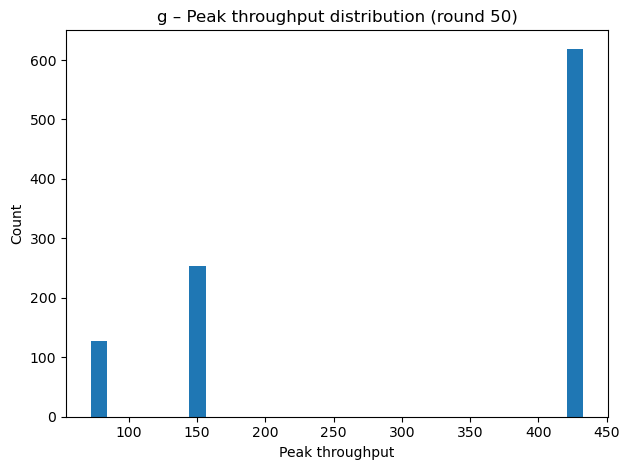

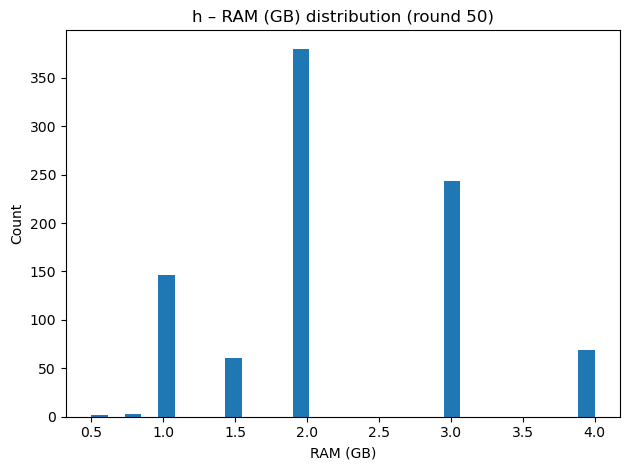

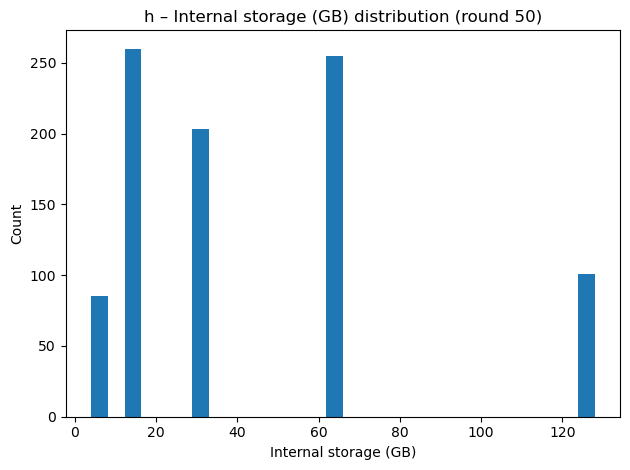

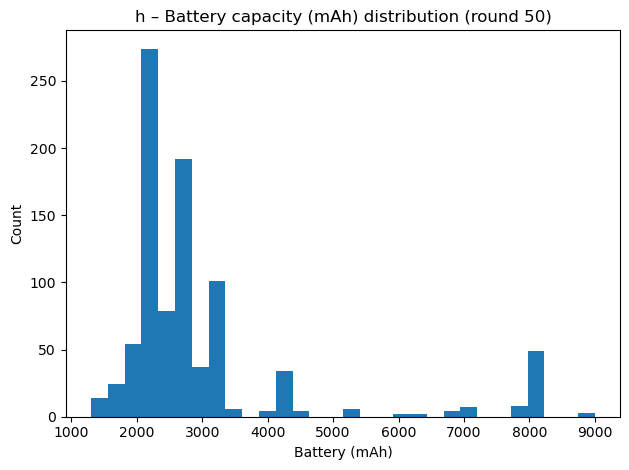

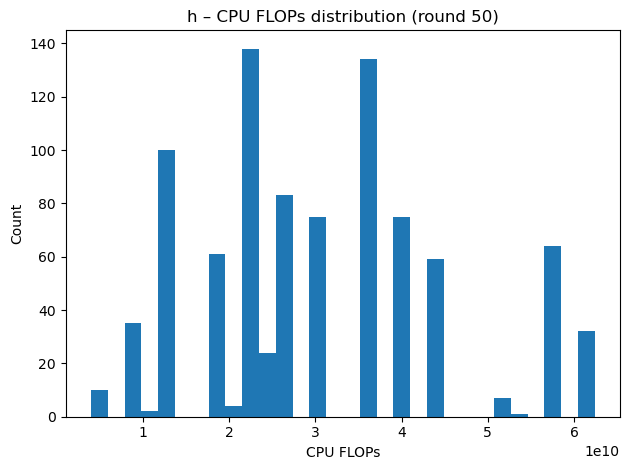

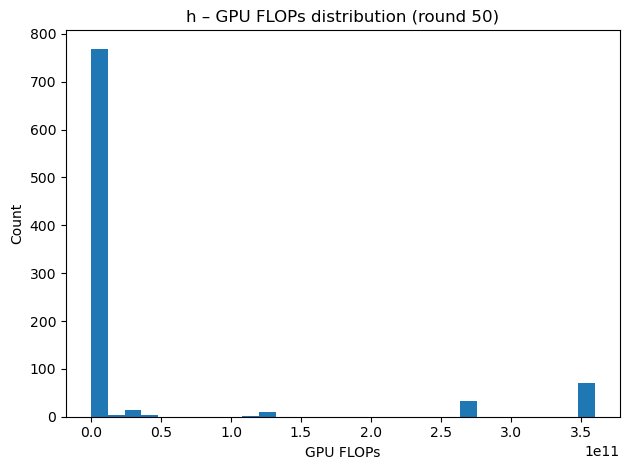

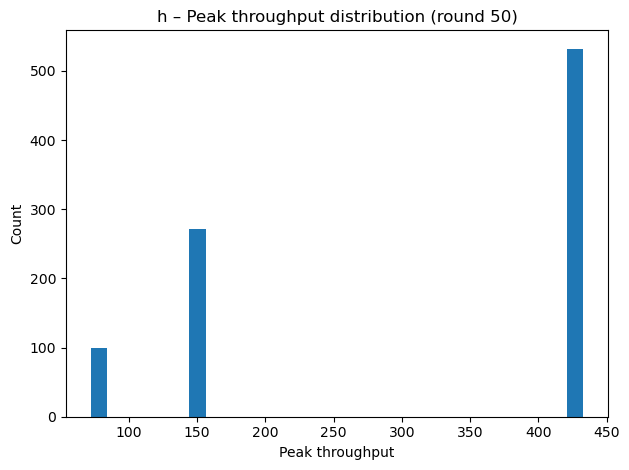

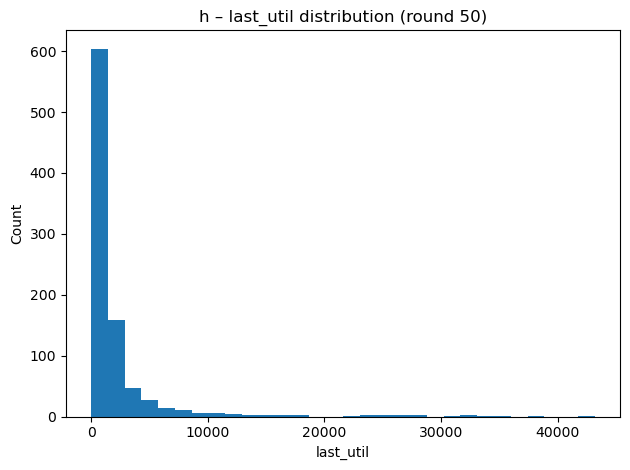

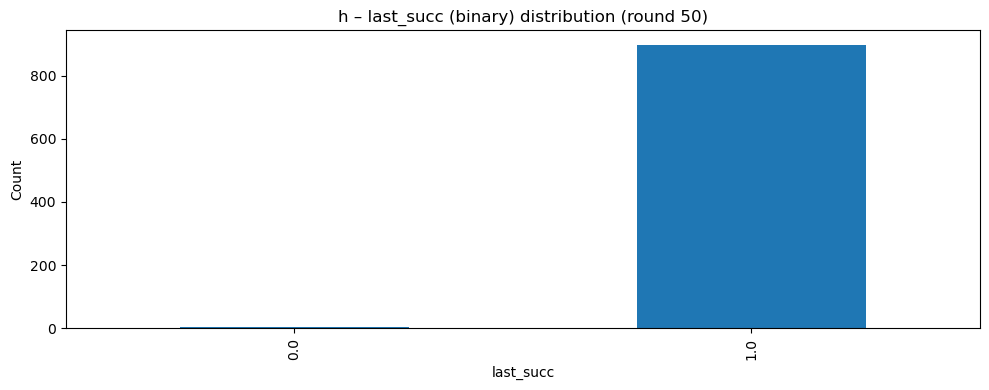

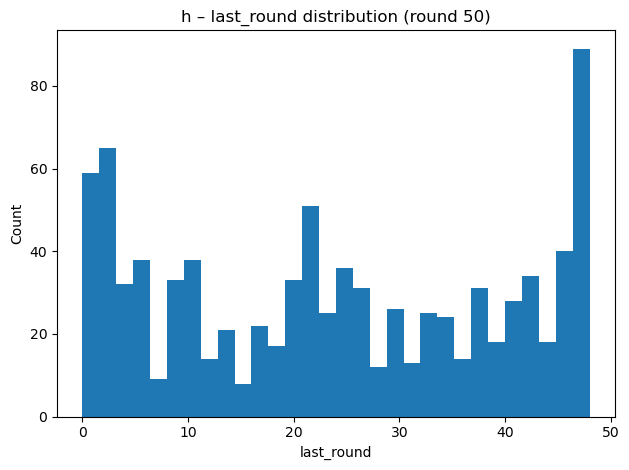

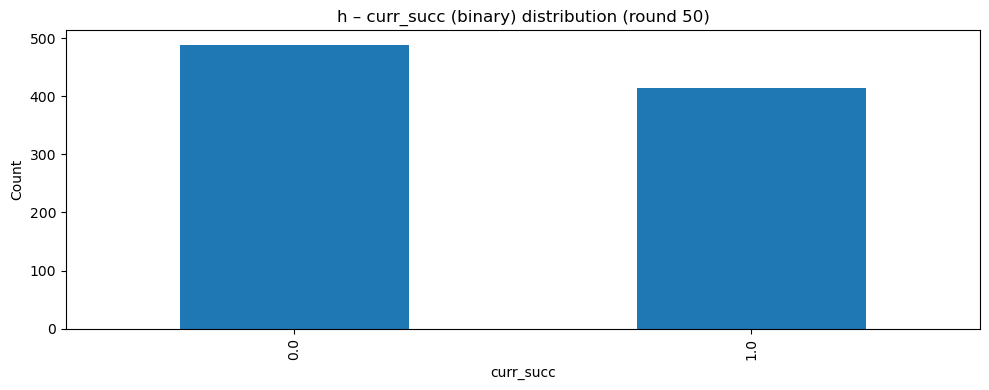

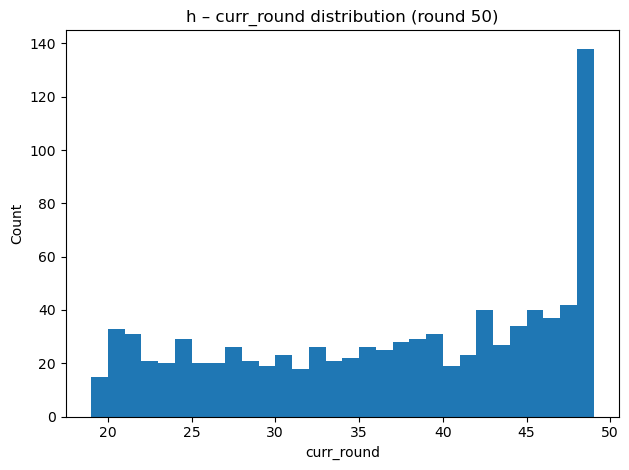

In [8]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Constants mirroring your encoders
# -----------------------------

OS_CODE_NAMES = [
    "Froyo", "Gingerbread", "Honeycomb", "Ice Cream Sandwich",
    "Jelly Bean", "KitKat", "Lollipop", "Marshmallow",
    "Nougat", "Oreo", "Pie",
]
LATEST_OS_RANK = len(OS_CODE_NAMES) - 1  # 10

BRANDS = [
    "Amazon", "LeEco", "YU", "Acer", "HP", "Samsung", "BQ", "Motorola",
    "Tesco", "Doogee", "iBall", "Asus", "Lenovo", "HTC", "LG", "Huawei",
    "Sony", "Silent Circle", "UMI", "Tecno", "Google", "OnePlus",
    "alcatel", "Wiko", "Nvidia", "Micromax", "ZTE", "BlackBerry",
]

# normalisation ranges used in the original encoder
RAM_MIN_GB, RAM_MAX_GB = 0.25, 4.0          # f72
INT_MIN_GB, INT_MAX_GB = 0.5, 128.0         # f73
BATT_MIN_MAH, BATT_MAX_MAH = 1300.0, 9600.0 # f74

CPU_MIN, CPU_MAX = 4_000_000_000, 67_200_000_000   # f75
GPU_MIN, GPU_MAX = 0, 360_000_000_000              # f76
THR_MIN, THR_MAX = 72, 433                         # f77

# indices for static encoded block f15..f77 (inclusive)
OS_START = 15        # f15, f16
OS_DIM = 2

BRAND_START = OS_START + OS_DIM         # f17..f44
BRAND_DIM = len(BRANDS)

# Model clusters: f45..f71 (27 dims)
CLUSTER_START = BRAND_START + BRAND_DIM

RAM_IDX = CLUSTER_START + 27            # f72
INT_MEM_IDX = RAM_IDX + 1               # f73
BATT_IDX = INT_MEM_IDX + 1              # f74
CPU_IDX = BATT_IDX + 1                  # f75
GPU_IDX = CPU_IDX + 1                   # f76
THR_IDX = GPU_IDX + 1                   # f77

# h-only extras
H_EXTRA_FEATURES = {
    78: "last_util",
    79: "last_succ",
    80: "last_round",
    81: "curr_succ",
    82: "curr_round",
}

# -----------------------------
# Decoding helpers
# -----------------------------

def decode_os_label(modernity: float, update_score: float) -> str:
    """Approximate the OS code-name from the encoded modernity/update_score."""
    eps = 1e-6
    if modernity < eps and update_score < eps:
        return "Unknown / non-Android"

    rank_float = modernity * LATEST_OS_RANK
    rank = int(round(rank_float))
    rank = max(0, min(rank, LATEST_OS_RANK))
    return OS_CODE_NAMES[rank]


def decode_ram_gb(ram_norm: float) -> float:
    return RAM_MIN_GB + ram_norm * (RAM_MAX_GB - RAM_MIN_GB)


def decode_internal_gb(int_norm: float) -> float:
    return INT_MIN_GB + int_norm * (INT_MAX_GB - INT_MIN_GB)


def decode_battery_mah(batt_norm: float) -> float:
    return BATT_MIN_MAH + batt_norm * (BATT_MAX_MAH - BATT_MIN_MAH)


def decode_cpu(cpu_norm: float) -> float:
    return CPU_MIN + cpu_norm * (CPU_MAX - CPU_MIN)


def decode_gpu(gpu_norm: float) -> float:
    return GPU_MIN + gpu_norm * (GPU_MAX - GPU_MIN)


def decode_thr(thr_norm: float) -> float:
    return THR_MIN + thr_norm * (THR_MAX - THR_MIN)


def load_cluster_labels(clusters_json_path: Path) -> list[str]:
    """
    Read clusters.json and return labels in the same order as the encoder:
    index 0 corresponds to clusters_json[0], etc.
    """
    with clusters_json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    # Use the "id" as the human-readable label
    return [str(obj["id"]) for obj in data]


# -----------------------------
# Plotting helpers
# -----------------------------

def plot_hist(series, title, xlabel=None):
    plt.figure()
    series = pd.Series(series).dropna()
    if series.empty:
        print(f"[WARN] No data to plot for: {title}")
        return
    plt.hist(series, bins=30)
    plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()


def plot_bar_from_values(values, title, xlabel=None):
    series = pd.Series(values)
    counts = series.value_counts().sort_index()
    plt.figure(figsize=(10, 4))
    counts.plot(kind="bar")
    plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()


# -----------------------------
# Main round-wise plotting
# -----------------------------

def plot_round_distributions(
    round_i: int,
    g_csv_path: Path,
    h_csv_path: Path,
    clusters_json_path: Path,
):
    # --- load data ---
    g_df = pd.read_csv(g_csv_path)
    h_df = pd.read_csv(h_csv_path)

    # Filter by round
    g_round = g_df[g_df["round"] == round_i].copy()
    h_round = h_df[h_df["round"] == round_i].copy()

    if g_round.empty:
        print(f"[WARN] No rows in g for round {round_i}")
    if h_round.empty:
        print(f"[WARN] No rows in h for round {round_i}")

    # Load cluster labels
    cluster_labels = load_cluster_labels(clusters_json_path)
    n_clusters = len(cluster_labels)
    assert n_clusters == 27, f"Expected 27 clusters, got {n_clusters}"

    # -------------------------
    # 1) Base 15 features f0..f14 (same for g and h)
    # -------------------------
    # Rates: f0..f4
    # Availabilities: f5..f9
    # BatteryLevels: f10..f14

    def plot_base_15(df_round, prefix: str):
        for idx in range(15):
            fname = f"f{idx}"
            if fname not in df_round.columns:
                print(f"[WARN] {prefix}: {fname} not in columns")
                continue
            title = f"{prefix} – {fname} distribution (round {round_i})"
            plot_hist(df_round[fname], title, xlabel=fname)

    plot_base_15(g_round, "g")
    plot_base_15(h_round, "h")

    # -------------------------
    # 2) Encoded OS (f15, f16)
    # -------------------------
    def plot_os(df_round, prefix: str):
        if not {"f15", "f16"}.issubset(df_round.columns):
            print(f"[WARN] {prefix}: f15/f16 missing, skipping OS plot")
            return

        modernity = df_round["f15"].astype(float).values
        update_score = df_round["f16"].astype(float).values

        os_labels = [
            decode_os_label(m, u) for m, u in zip(modernity, update_score)
        ]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # left: categorical OS labels
        os_counts = pd.Series(os_labels).value_counts()
        os_counts.plot(kind="bar", ax=axes[0])
        axes[0].set_title(f"{prefix} – OS code-name distribution (round {round_i})")
        axes[0].set_xlabel("OS")
        axes[0].set_ylabel("Count")

        # right: update_score histogram
        axes[1].hist(update_score, bins=30)
        axes[1].set_title(f"{prefix} – OS update_score distribution (round {round_i})")
        axes[1].set_xlabel("update_score")
        axes[1].set_ylabel("Count")

        fig.tight_layout()

    plot_os(g_round, "g")
    plot_os(h_round, "h")

    # -------------------------
    # 3) Brand (f17..f44) one-hot
    # -------------------------
    def plot_brand(df_round, prefix: str):
        brand_cols = [f"f{BRAND_START + i}" for i in range(len(BRANDS))]
        missing = [c for c in brand_cols if c not in df_round.columns]
        if missing:
            print(f"[WARN] {prefix}: missing brand cols {missing}, skipping brand")
            return

        brand_mat = df_round[brand_cols].values.astype(float)
        max_vals = brand_mat.max(axis=1)
        idxs = brand_mat.argmax(axis=1)
        labels = []
        for max_val, idx in zip(max_vals, idxs):
            if max_val <= 0:
                labels.append("Unknown")
            else:
                labels.append(BRANDS[idx])

        plot_bar_from_values(
            labels,
            f"{prefix} – Brand distribution (round {round_i})",
            xlabel="Brand",
        )

    plot_brand(g_round, "g")
    plot_brand(h_round, "h")

    # -------------------------
    # 4) Model cluster (f45..f71) one-hot
    # -------------------------
    def plot_cluster(df_round, prefix: str):
        cluster_cols = [f"f{CLUSTER_START + i}" for i in range(len(cluster_labels))]
        missing = [c for c in cluster_cols if c not in df_round.columns]
        if missing:
            print(f"[WARN] {prefix}: missing cluster cols {missing}, skipping clusters")
            return

        cl_mat = df_round[cluster_cols].values.astype(float)
        max_vals = cl_mat.max(axis=1)
        idxs = cl_mat.argmax(axis=1)
        labels = []
        for max_val, idx in zip(max_vals, idxs):
            if max_val <= 0:
                labels.append("Unknown")
            else:
                labels.append(f"cluster_{cluster_labels[idx]}")

        plot_bar_from_values(
            labels,
            f"{prefix} – Model-cluster distribution (round {round_i})",
            xlabel="Cluster ID",
        )

    plot_cluster(g_round, "g")
    plot_cluster(h_round, "h")

    # -------------------------
    # 5) RAM, internal memory, battery, CPU, GPU, throughput
    #    RAM: f72, internal: f73, batt: f74, CPU: f75, GPU: f76, thr: f77
    # -------------------------
    def plot_hw(df_round, prefix: str):
        cols_needed = [f"f{i}" for i in range(RAM_IDX, THR_IDX + 1)]
        missing = [c for c in cols_needed if c not in df_round.columns]
        if missing:
            print(f"[WARN] {prefix}: missing hw cols {missing}, skipping hw block")
            return

        ram_gb = decode_ram_gb(df_round[f"f{RAM_IDX}"].astype(float))
        plot_hist(ram_gb, f"{prefix} – RAM (GB) distribution (round {round_i})", xlabel="RAM (GB)")

        int_gb = decode_internal_gb(df_round[f"f{INT_MEM_IDX}"].astype(float))
        plot_hist(int_gb, f"{prefix} – Internal storage (GB) distribution (round {round_i})",
                  xlabel="Internal storage (GB)")

        batt_mah = decode_battery_mah(df_round[f"f{BATT_IDX}"].astype(float))
        plot_hist(batt_mah, f"{prefix} – Battery capacity (mAh) distribution (round {round_i})",
                  xlabel="Battery (mAh)")

        cpu_val = decode_cpu(df_round[f"f{CPU_IDX}"].astype(float))
        plot_hist(cpu_val, f"{prefix} – CPU FLOPs distribution (round {round_i})",
                  xlabel="CPU FLOPs")

        gpu_val = decode_gpu(df_round[f"f{GPU_IDX}"].astype(float))
        plot_hist(gpu_val, f"{prefix} – GPU FLOPs distribution (round {round_i})",
                  xlabel="GPU FLOPs")

        thr_val = decode_thr(df_round[f"f{THR_IDX}"].astype(float))
        plot_hist(thr_val, f"{prefix} – Peak throughput distribution (round {round_i})",
                  xlabel="Peak throughput")

    plot_hw(g_round, "g")
    plot_hw(h_round, "h")

    # -------------------------
    # 6) h-only extra features f78..f82
    #     last_util, last_succ, last_round, curr_succ, curr_round
    # -------------------------
    def plot_h_extras(df_round):
        for idx, name in H_EXTRA_FEATURES.items():
            col = f"f{idx}"
            if col not in df_round.columns:
                print(f"[WARN] h: {col} ({name}) missing, skipping")
                continue

            s = df_round[col].astype(float)

            # binary: use bar; else histogram
            unique_vals = sorted(s.dropna().unique())
            if set(unique_vals).issubset({0.0, 1.0}) and len(unique_vals) <= 2:
                plot_bar_from_values(
                    s.values,
                    f"h – {name} (binary) distribution (round {round_i})",
                    xlabel=name,
                )
            else:
                plot_hist(
                    s,
                    f"h – {name} distribution (round {round_i})",
                    xlabel=name,
                )

    plot_h_extras(h_round)

    print("Done plotting all distributions for round", round_i)


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # TODO: replace these with your actual file names
    base_dir = Path("datasets/openimage_bliss")

    g_csv = sorted(base_dir.glob("g_*.csv"))[-1]
    h_csv = sorted(base_dir.glob("h_*.csv"))[-1]
    clusters_json = Path("../clusters.json")

    round_i = 50

    plot_round_distributions(
        round_i=round_i,
        g_csv_path=g_csv,
        h_csv_path=h_csv,
        clusters_json_path=clusters_json,
    )

    # Show all figures at the end
    plt.show()
